In [1]:
from keras.datasets import mnist 

# MNIST Load Normalization
(x_train, _), (x_test, _) = mnist.load_data()
y_train = x_train[:1000].astype('float32') / 255.
y_test = x_test[:1000].astype('float32') / 255. 

print(y_train.shape)
print(y_test.shape)

Using TensorFlow backend.


(1000, 28, 28)
(1000, 28, 28)


In [2]:
# conv2d input reshape (width*height*cannel)
y_train = y_train.reshape((y_train.shape[0],28,28,1))
y_test = y_test.reshape((y_test.shape[0],28,28,1))
print(y_train.shape)
print(y_test.shape)

(1000, 28, 28, 1)
(1000, 28, 28, 1)


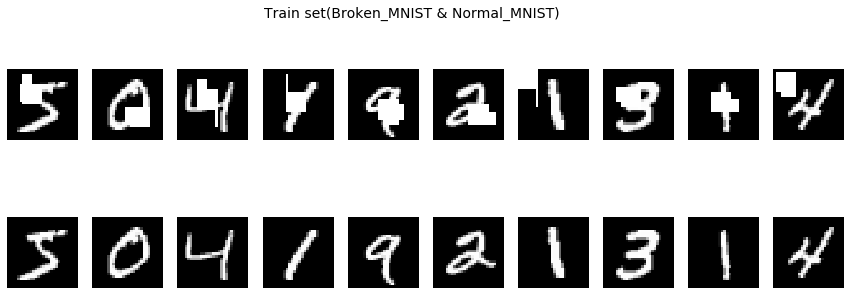

In [13]:
import numpy as np 
import matplotlib.pyplot as plt 

x_train = y_train.copy()

# noise range
rn = 8

# 랜덤 깨진 MNISt 만들기 
for i in range(0, x_train.shape[0]) : 
    ix = np.random.randint(0, x_train.shape[1]-rn)
    iz = np.random.randint(0, x_train.shape[1]-rn)
    ic = np.random.randint(0, x_train.shape[1]-rn)
    x_train[i, ic:ix+rn , ix:ic+rn] = 1.
    x_train[i, iz:ic+rn , ic:iz+rn] = 1.
    x_train[i, ic:ic+rn , ic:ic+rn] = 1.

fig, axs = plt.subplots(2,10, figsize=(15, 5))
for i in range(10) :
    fig.suptitle('Train set(Broken_MNIST & Normal_MNIST)', fontsize=14)
    axs[0, i].set_axis_off()
    axs[0, i].imshow(x_train[i].reshape(28,28), cmap='gray')
    axs[1, i].set_axis_off()
    axs[1, i].imshow(y_train[i].reshape(28,28), cmap='gray')
plt.show()
plt.close(fig)

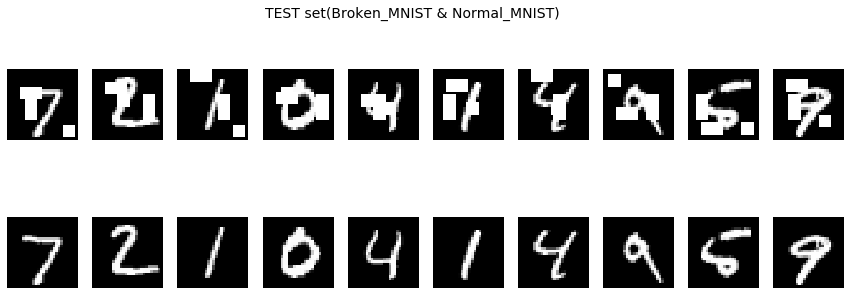

In [5]:
x_test = y_test.copy()

# 랜덤 깨진 MNISt 만들기 
for i in range(0, x_test.shape[0]) : 
    ix = np.random.randint(0, x_test.shape[1]-rn)
    iz = np.random.randint(0, x_test.shape[1]-rn)
    ic = np.random.randint(0, x_test.shape[1]-rn)
    x_test[i, 10:20, ix:ix+rn] = 1.
    x_test[i, iz:iz+rn , 5:14] = 1.
    x_test[i, ic:ic+rn , ic:ic+rn] = 1.

fig, axs = plt.subplots(2,10, figsize=(15, 5))
for i in range(10) :
    fig.suptitle('TEST set(Broken_MNIST & Normal_MNIST)', fontsize=14)
    axs[0, i].set_axis_off()
    axs[0, i].imshow(x_test[i].reshape(28,28), cmap='gray')
    axs[1, i].set_axis_off()
    axs[1, i].imshow(y_test[i].reshape(28,28), cmap='gray')
plt.show()
plt.close(fig)

In [5]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, MaxPooling2D, Conv2DTranspose, concatenate
from tensorflow.keras import backend as keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler


def unet(input_size=(28,28,1)):
    inputs = Input(input_size)
    depth = 14

    conv1 = Conv2D(depth*1, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = BatchNormalization()(conv1)
    conv1 = Conv2D(depth*1, (3, 3), activation='relu', padding='same')(conv1)
    conv1 = BatchNormalization()(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(depth*2, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = BatchNormalization()(conv2)
    conv2 = Conv2D(depth*2, (3, 3), activation='relu', padding='same')(conv2)
    conv2 = BatchNormalization()(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(depth*4, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = BatchNormalization()(conv3)
    conv3 = Conv2D(depth*4, (3, 3), activation='relu', padding='same')(conv3)
    conv3 = BatchNormalization()(conv3)

    up1 = concatenate([Conv2DTranspose(depth*2, (2, 2), strides=(2, 2), padding='same')(conv3), conv2], axis=3)
    dconv1 = Conv2D(depth*2, (3, 3), activation='relu', padding='same')(up1)
    dconv1 = BatchNormalization()(dconv1)
    dconv1 = Conv2D(depth*2, (3, 3), activation='relu', padding='same')(dconv1)
    dconv1 = BatchNormalization()(dconv1)

    up2 = concatenate([Conv2DTranspose(depth*1, (2, 2), strides=(2, 2), padding='same')(dconv1), conv1], axis=3)
    dconv2 = Conv2D(depth*1, (3, 3), activation='relu', padding='same')(up2)
    dconv2 = BatchNormalization()(dconv2)
    dconv2 = Conv2D(depth*1, (3, 3), activation='relu', padding='same')(dconv2)
    dconv2 = BatchNormalization()(dconv2)

    outputs = Conv2D(1, (1, 1), activation='sigmoid')(dconv2)
    return Model(inputs=[inputs], outputs=[outputs])

model = unet()

model.compile(loss="binary_crossentropy", optimizer="adam", metrics=['accuracy'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 28, 28, 14)   140         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 28, 28, 14)   56          conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 28, 28, 14)   1778        batch_normalization[0][0]        
______________________________________________________________________________________________

In [6]:
# 학습
hist = model.fit(x_train, y_train, validation_split=0.3, epochs=10, batch_size=3, verbose=1)

# 모델 저장
model.save('unet.h5')

Train on 700 samples, validate on 300 samples
Epoch 1/10
700/700 [==============================] - 4s 5ms/sample - loss: 0.3165 - accuracy: 0.7828 - val_loss: 0.4214 - val_accuracy: 0.7209
Epoch 2/10
700/700 [==============================] - 1s 2ms/sample - loss: 0.1410 - accuracy: 0.8155 - val_loss: 0.1732 - val_accuracy: 0.7718
Epoch 3/10
700/700 [==============================] - 1s 2ms/sample - loss: 0.1103 - accuracy: 0.8164 - val_loss: 0.1073 - val_accuracy: 0.7986
Epoch 4/10
700/700 [==============================] - 1s 2ms/sample - loss: 0.0991 - accuracy: 0.8166 - val_loss: 0.1055 - val_accuracy: 0.8057
Epoch 5/10
700/700 [==============================] - 1s 2ms/sample - loss: 0.0904 - accuracy: 0.8171 - val_loss: 0.1129 - val_accuracy: 0.8055
Epoch 6/10
700/700 [==============================] - 1s 2ms/sample - loss: 0.0859 - accuracy: 0.8174 - val_loss: 0.0937 - val_accuracy: 0.8035
Epoch 7/10
700/700 [==============================] - 1s 2ms/sample - loss: 0.0814 - accur

No handles with labels found to put in legend.


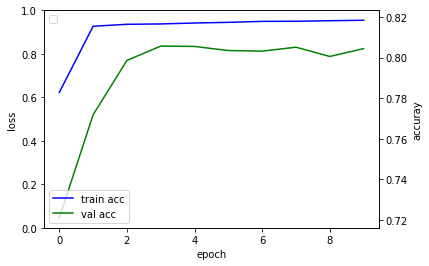

In [7]:

fig, loss_ax = plt.subplots()

acc_ax = loss_ax.twinx()

# loss_ax.plot(hist.history['loss'], 'y', label='train loss')
# loss_ax.plot(hist.history['val_loss'], 'r', label='val loss')
# loss_ax.set_ylim([0.0, 1.0])

acc_ax.plot(hist.history['accuracy'], 'b', label='train acc')
acc_ax.plot(hist.history['val_accuracy'], 'g', label='val acc')
# acc_ax.set_ylim([0.0, 1.0])

loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
acc_ax.set_ylabel('accuray')

loss_ax.legend(loc='upper left')
acc_ax.legend(loc='lower left')

plt.show()
plt.close()

1/1 [==============================] - 0s 216ms/sample - loss: 0.1385 - accuracy: 0.7666


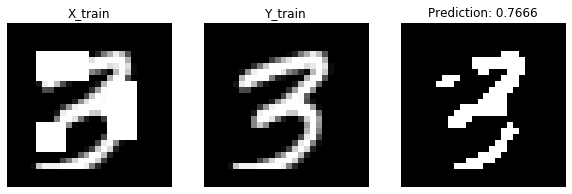

In [8]:

ix = np.random.randint(0, len(x_train))

input_ = x_train[ix:ix+1]
mask_ = y_train[ix:ix+1]

preds_train = model.predict(input_)
preds_train_t = (preds_train > 0.5).astype(np.uint8)

plt.figure(figsize=(10,10))
plt.subplot(1,3,1)
plt.title("X_train")
plt.axis('off')
plt.imshow(input_[0].reshape((28,28)), 'gray')
plt.subplot(1,3,2)
plt.title("Y_train")
plt.axis('off')
plt.imshow(mask_[0][:,:,0], 'gray')
plt.subplot(1,3,3)
ret = model.evaluate(input_, mask_)
plt.title("Prediction: %.4f" % (ret[1]))
plt.axis('off')
plt.imshow(preds_train_t[0][:,:,0], 'gray')
plt.show()
plt.close()

1/1 [==============================] - 0s 4ms/sample - loss: 0.0764 - accuracy: 0.7793


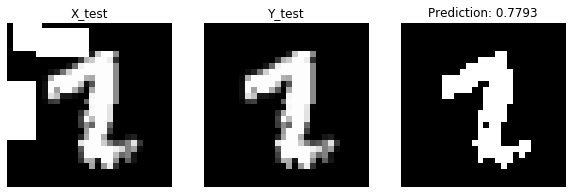

In [9]:
ix = np.random.randint(0, len(x_test))
input_ = x_test[ix:ix+1]
mask_ = y_test[ix:ix+1]
preds_test = model.predict(input_)
preds_test_t = (preds_test > 0.5).astype(np.uint8)

plt.figure(figsize=(10,10))
plt.subplot(1,3,1)
plt.title("X_test")
plt.axis('off')

plt.imshow(input_[0].reshape((28,28)), 'gray')
plt.subplot(1,3,2)
plt.title("Y_test")
plt.axis('off')

plt.imshow(mask_[0][:,:,0], 'gray')
plt.subplot(1,3,3)
ret = model.evaluate(input_, mask_)
plt.title("Prediction: %.4f" % (ret[1]))
plt.axis('off')

plt.imshow(preds_test_t[0][:,:,0], 'gray')
plt.show()
plt.close()

In [14]:
residual = input_ - preds_test_t
residual_ = residual.reshape((28,28,3))


NameError: name 'input_' is not defined

In [11]:
rows, cols, channels = test_residual_.shape
pixel_value_to_replace = 255
# changing 255 to 0 in first channel
for i in range(rows):
    for j in range(cols):
        if test_residual_[i, j, :] == 1 :
            test_residual_[i, j, :] = 255

(28, 28)


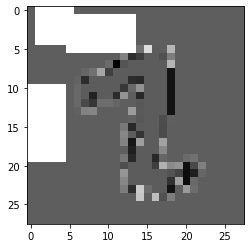

In [12]:
plt.imshow(residual, 'gray')
plt.show()
plt.close()

In [28]:
import cv2 

img = cv2.imread(residual)

ModuleNotFoundError: No module named 'cv2'

In [27]:
print(residual.shape)
len_res = len(residual)

for i in range(0, len_res) : 
    print(residual[i])
    residual[i] = 

(28, 28)
[0. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]
[0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]
[0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]
[0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]
[0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]
[ 0.          0.          0.          0.          0.          1.
  1.          1.          1.          1.          1.          1.
  1.          1.          0.11764706  0.7921569  -0.00392157  0.
  0.54509807  0.          0.          0.          0.          0.
  0.          0.          0.          0.        ]
[ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.22745098 -0.29411763 -0.19999999 -0.00784314 -0.00784314 -0.07058823
  0.19215687  0.          0.          0.   